In [8]:
import pandas as pd
import numpy as np
import pickle
from tqdm.auto import tqdm
import re
import time
import csv
import os
import matplotlib.pyplot as plt

In [9]:
import sys
print(sys.executable)

F:\Projtest\pjtest\Scripts\python.exe


In [10]:
# 시각화 한글폰트
from matplotlib import font_manager, rc
font_path = "C:/Windows/Fonts/malgun.ttf"  # Windows의 맑은 고딕 폰트 경로
font_name = font_manager.FontProperties(fname=font_path).get_name()
rc('font', family=font_name)

In [26]:
# Load the CSV file
# 기본 경로 지정
base_path = 'F:/cluster_test_2024/search_results_2024_06-04_combined'
filename = 'df_combined_search_results_uid-year-techfull_only.csv'
# 파일의 전체 경로
file_path = os.path.join(base_path, filename)
df_pub = pd.read_csv(file_path)

In [27]:
# Drop the unnamed column
df_pub = df_pub.drop(columns=['Unnamed: 0'])

In [40]:
df_pub.drop_duplicates()

,uid,pubyear,key
0,WOS:000327686700011,2013,01. 금속 3D 프린팅(gpt_wo_abbr.)
1,WOS:000320972600005,2013,01. 금속 3D 프린팅(gpt_wo_abbr.)
2,WOS:000341631200006,2014,01. 금속 3D 프린팅(gpt_wo_abbr.)
3,WOS:000457238400006,2015,01. 금속 3D 프린팅(gpt_wo_abbr.)
4,WOS:000387298300030,2016,01. 금속 3D 프린팅(gpt_wo_abbr.)
...,...,...,...
602146,WOS:000477964600015,2019,A1. 금속 3D 프린팅(largest_w_abbr.)
602147,WOS:000483699900005,2019,A1. 금속 3D 프린팅(largest_w_abbr.)
602148,WOS:000469357900009,2019,A1. 금속 3D 프린팅(largest_w_abbr.)
602149,WOS:000754604800030,2021,A1. 금속 3D 프린팅(largest_w_abbr.)


In [41]:
df_pub

,uid,pubyear,key
0,WOS:000327686700011,2013,01. 금속 3D 프린팅(gpt_wo_abbr.)
1,WOS:000320972600005,2013,01. 금속 3D 프린팅(gpt_wo_abbr.)
2,WOS:000341631200006,2014,01. 금속 3D 프린팅(gpt_wo_abbr.)
3,WOS:000457238400006,2015,01. 금속 3D 프린팅(gpt_wo_abbr.)
4,WOS:000387298300030,2016,01. 금속 3D 프린팅(gpt_wo_abbr.)
...,...,...,...
602146,WOS:000477964600015,2019,A1. 금속 3D 프린팅(largest_w_abbr.)
602147,WOS:000483699900005,2019,A1. 금속 3D 프린팅(largest_w_abbr.)
602148,WOS:000469357900009,2019,A1. 금속 3D 프린팅(largest_w_abbr.)
602149,WOS:000754604800030,2021,A1. 금속 3D 프린팅(largest_w_abbr.)


In [28]:
# Get unique keys
keys = df_pub['key'].unique()

In [16]:
keys

array(['01. 금속 3D 프린팅(gpt_wo_abbr.)', '02. 신축성 전자소자', '03. 휴먼 마이크로바이옴',
       '04. 암 진단_예측 바이오마커', '05. 유전자 편집', '06.무선 전력 전송',
       '07. 초대용량 데이터 대응 광통신 기술_gpt', '08. 면역세포치료', '09. 나노유체 이용 에너지 효율화',
       '10. 상변화 소재 활용 열에너지 저장', 'A1. 금속 3D 프린팅(largest_w_abbr.)'],
      dtype=object)

In [29]:
df_pub['pubyear'].unique()

array([2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023,
       2006, 2009, 2007, 2008, 2011, 2012, 2010])

In [30]:
# Group by 'key' and 'pubyear', and count the unique 'uid' entries for each group
grouped_df = df_pub.groupby(['key', 'pubyear']).agg(uid_count=('uid', 'nunique')).reset_index()

In [31]:
grouped_df

,key,pubyear,uid_count
0,01. 금속 3D 프린팅(gpt_wo_abbr.),2006,13
1,01. 금속 3D 프린팅(gpt_wo_abbr.),2007,11
2,01. 금속 3D 프린팅(gpt_wo_abbr.),2008,8
3,01. 금속 3D 프린팅(gpt_wo_abbr.),2009,9
4,01. 금속 3D 프린팅(gpt_wo_abbr.),2010,3
...,...,...,...
193,A1. 금속 3D 프린팅(largest_w_abbr.),2019,1155
194,A1. 금속 3D 프린팅(largest_w_abbr.),2020,1438
195,A1. 금속 3D 프린팅(largest_w_abbr.),2021,1693
196,A1. 금속 3D 프린팅(largest_w_abbr.),2022,1908


In [32]:
max(df_pub['pubyear'].unique())

np.int64(2023)

# reference 대용량 csv파일 불러오기 트릭
## - 샘플 확인하여 사용할 컬럼 확정

In [23]:
use_cols = ['uid', 'ref_count', 'ref_uid', 'ref_occurence_order','ref_year']

In [24]:
import time

chunksize = 100000000 # 1억 !!!
chunk_list = []  # append each chunk df here 

total_rows = 0
chunk_number = 0

In [25]:
start_time = time.time()
# Read the CSV file in chunks with tqdm progress bar
for chunk in pd.read_csv('F:\cluster_test_2024\wos2413db_pkls\combined_df_web_of_science_2413_raw_reference.csv', sep=',', usecols=use_cols, chunksize=chunksize):
    chunk_number += 1
    total_rows += len(chunk)
    chunk_list.append(chunk)
    
    elapsed_time = time.time() - start_time
    
    print(f"Chunk number: {chunk_number}, Elapsed time: {elapsed_time:.2f} seconds, Total rows: {total_rows}")

# Concatenate all chunks into one DataFrame (if needed)
df = pd.concat(chunk_list)
#shape (1, 1594398232)
#Chunk number: 16, Elapsed time: 2265.23 seconds, Total rows: 1594398232

Chunk number: 1, Elapsed time: 120.59 seconds, Total rows: 100000000
Chunk number: 2, Elapsed time: 240.70 seconds, Total rows: 200000000
Chunk number: 3, Elapsed time: 362.58 seconds, Total rows: 300000000
Chunk number: 4, Elapsed time: 484.81 seconds, Total rows: 400000000
Chunk number: 5, Elapsed time: 607.83 seconds, Total rows: 500000000
Chunk number: 6, Elapsed time: 730.83 seconds, Total rows: 600000000
Chunk number: 7, Elapsed time: 854.67 seconds, Total rows: 700000000
Chunk number: 8, Elapsed time: 971.89 seconds, Total rows: 800000000
Chunk number: 9, Elapsed time: 1090.30 seconds, Total rows: 900000000
Chunk number: 10, Elapsed time: 1209.07 seconds, Total rows: 1000000000
Chunk number: 11, Elapsed time: 1330.34 seconds, Total rows: 1100000000
Chunk number: 12, Elapsed time: 1450.83 seconds, Total rows: 1200000000
Chunk number: 13, Elapsed time: 1570.69 seconds, Total rows: 1300000000
Chunk number: 14, Elapsed time: 1694.53 seconds, Total rows: 1400000000
Chunk number: 15, 

In [33]:
# Merge the two dataframes on 'uid'
merged_df = pd.merge(df_pub, df, on='uid', how = 'left')

In [34]:
merged_df.shape

(35076001, 7)

In [38]:
merged_df[merged_df['ref_uid'].isna()]

,uid,pubyear,key,ref_count,ref_uid,ref_occurence_order,ref_year
26580,WOS:000476619300005,2019,01. 금속 3D 프린팅(gpt_wo_abbr.),NaN,NaN,NaN,NaN
46398,WOS:000238056400300,2006,01. 금속 3D 프린팅(gpt_wo_abbr.),NaN,NaN,NaN,NaN
106150,WOS:000512216900095,2020,02. 신축성 전자소자,NaN,NaN,NaN,NaN
138139,WOS:001037240900030,2023,02. 신축성 전자소자,NaN,NaN,NaN,NaN
166791,WOS:000462751600002,2019,02. 신축성 전자소자,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...
35061342,WOS:001161670600120,2023,A1. 금속 3D 프린팅(largest_w_abbr.),22.0,NaN,3.0,0.0
35061559,WOS:001150369700055,2023,A1. 금속 3D 프린팅(largest_w_abbr.),NaN,NaN,NaN,NaN
35061748,WOS:001061570000008,2023,A1. 금속 3D 프린팅(largest_w_abbr.),141.0,NaN,128.0,0.0
35061839,WOS:001061570000008,2023,A1. 금속 3D 프린팅(largest_w_abbr.),141.0,NaN,88.0,0.0


In [42]:
missing = merged_df[merged_df['ref_uid'].isna()]

In [43]:
len(missing['uid'].unique())

1778

In [44]:
len(merged_df['uid'].unique())

584385

In [46]:
## ref_uid nan 제거
merged_df = merged_df[~merged_df['ref_uid'].isna()]

In [47]:
# Calculate the age of each reference
merged_df['ref_age'] = merged_df['pubyear'] - merged_df['ref_year']

C:\Users\skim\AppData\Local\Temp\ipykernel_15712\4057538642.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_df['ref_age'] = merged_df['pubyear'] - merged_df['ref_year']


In [48]:
# Function to calculate the median age of references for each group
def calculate_group_tct(df):
    return df['ref_age'].median()

In [49]:
# Apply the function to calculate TCT for each 'key' and 'pubyear'
group_tct_values = merged_df.groupby(['key', 'pubyear']).apply(calculate_group_tct).reset_index()
group_tct_values.columns = ['key', 'pubyear', 'TCT']

C:\Users\skim\AppData\Local\Temp\ipykernel_15712\1655665138.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  group_tct_values = merged_df.groupby(['key', 'pubyear']).apply(calculate_group_tct).reset_index()


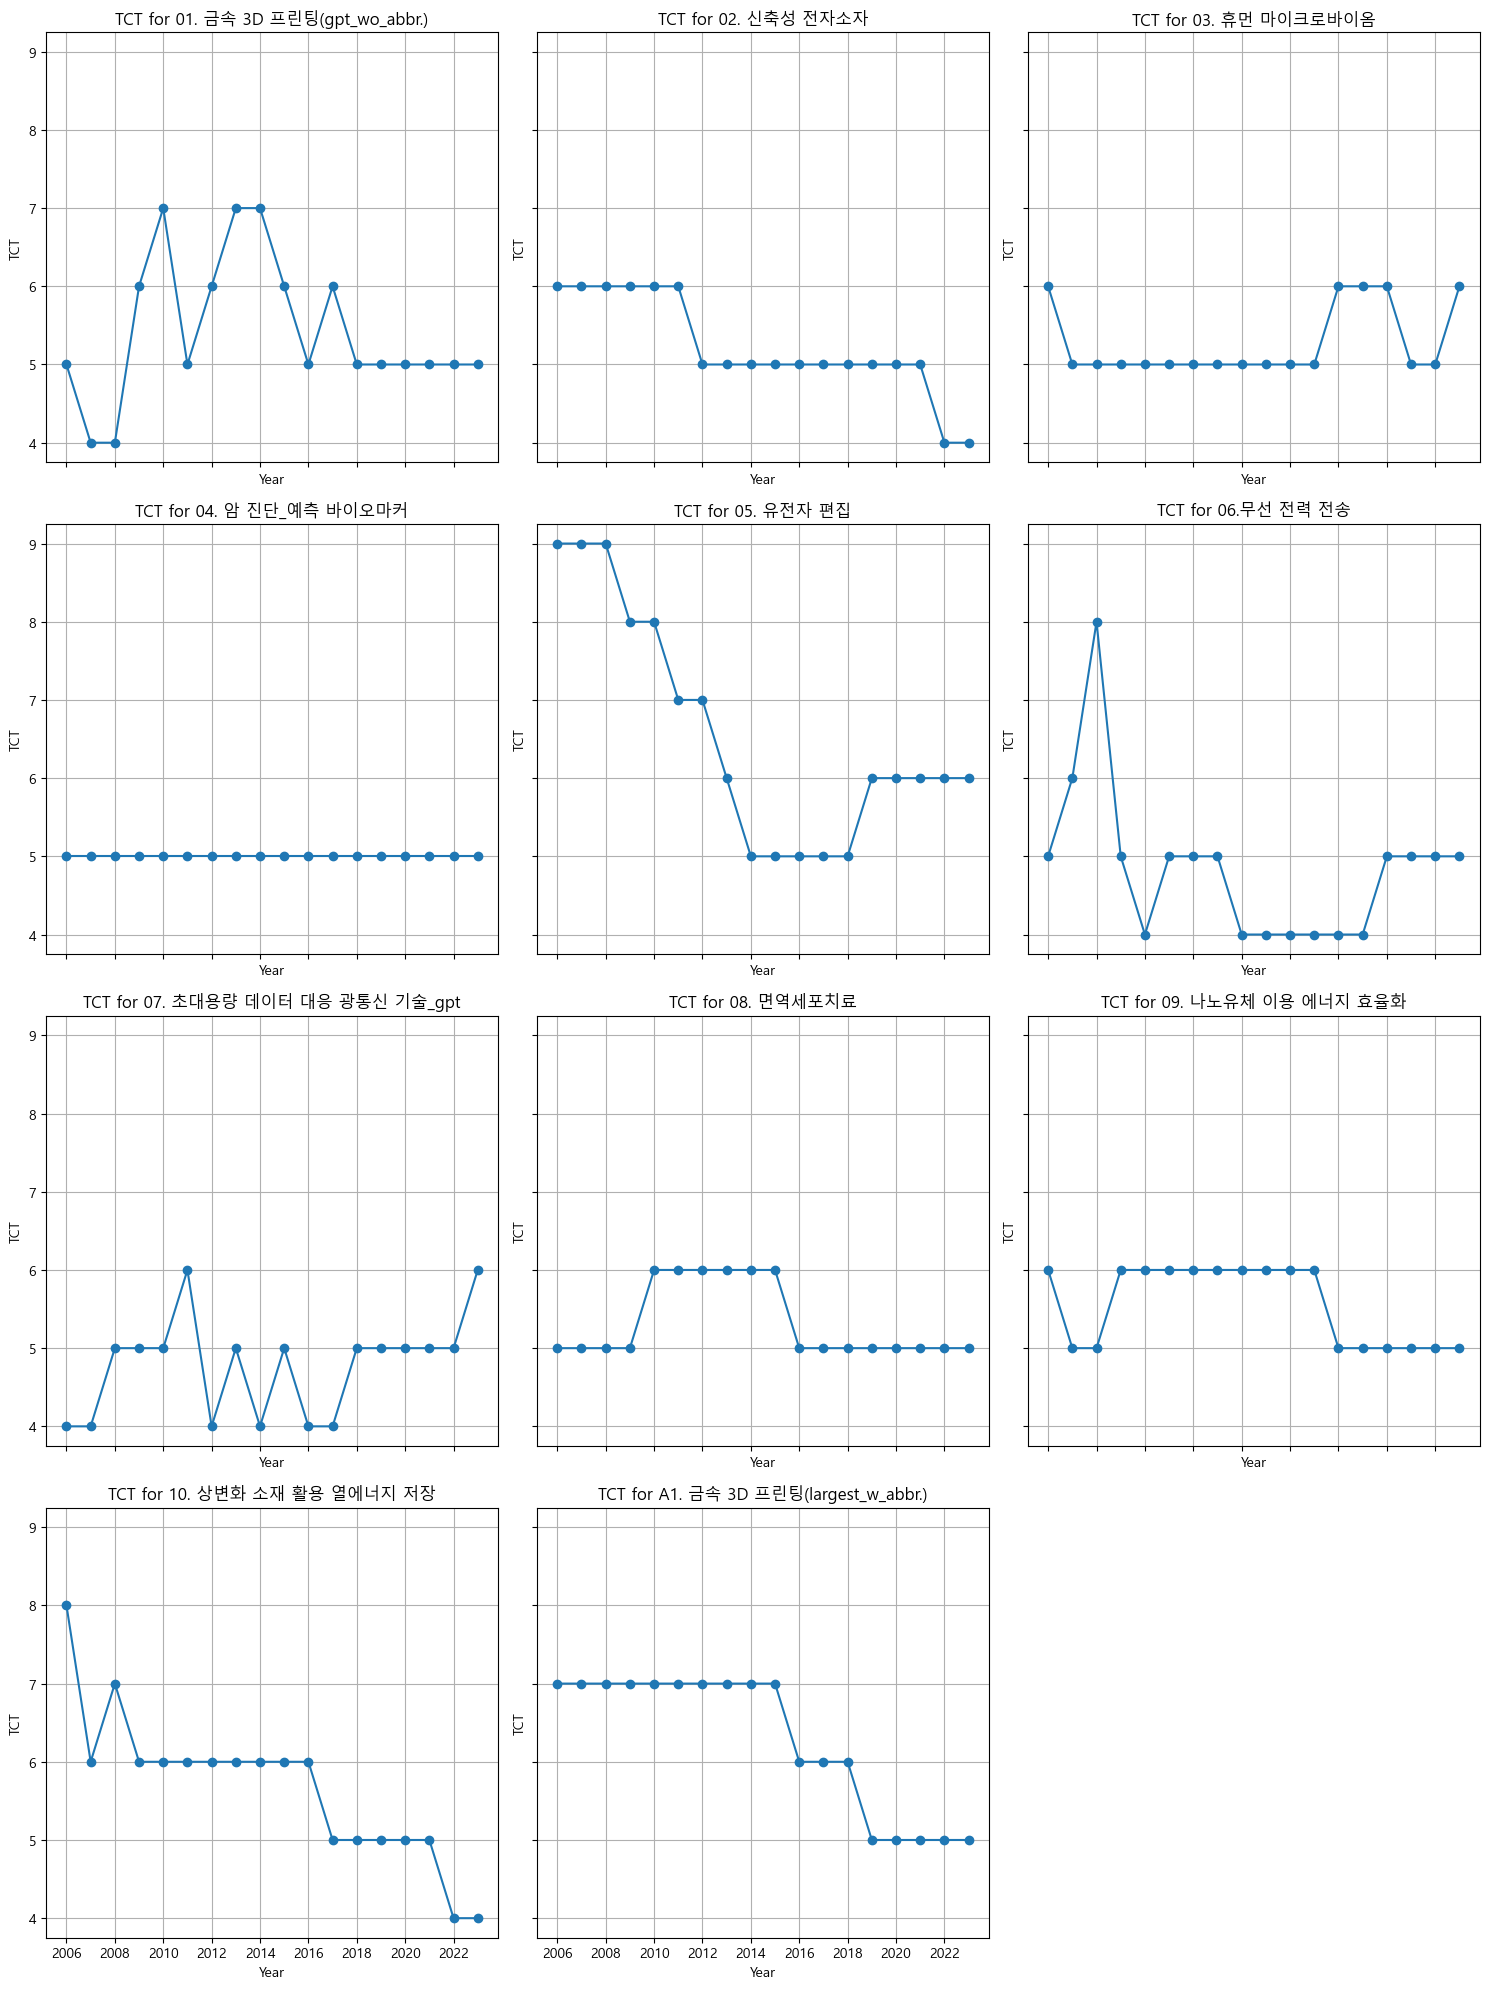

In [53]:
# Plotting the TCT values for each technology and year
unique_keys = group_tct_values['key'].unique()
num_keys = len(unique_keys)

# Determine number of rows needed for subplot grid
num_cols = 3
num_rows = (num_keys + num_cols - 1) // num_cols

fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 5 * num_rows), sharex=True, sharey=True)
axes = axes.flatten()

for idx, key in enumerate(unique_keys):
    ax = axes[idx]
    tech_data = group_tct_values[group_tct_values['key'] == key]
    ax.plot(tech_data['pubyear'], tech_data['TCT'], marker='o')
    ax.set_title(f'TCT for {key}')
    ax.set_xlabel('Year')
    ax.set_ylabel('TCT')
    ax.grid(True)

    # x축 눈금을 2년 간격으로 설정
    years = tech_data['pubyear'].astype(int)
    min_year = years.min()
    max_year = years.max()
    ax.set_xticks(range(min_year, max_year + 1, 2))
    ax.set_xticklabels(range(min_year, max_year + 1, 2))

# Hide any unused subplots
for idx in range(len(unique_keys), len(axes)):
    fig.delaxes(axes[idx])

plt.tight_layout()
# 파일로 저장
plt.savefig('TCT_visualization.png', format='png')
plt.show()